---
# Aggregate .sro mass balance by month & plot
Create graphic for oil spill fate by "location category" 
i.e. water column, water surface, beach, and air (evaporation)
---

#### Steps for generating this graphic

1. Oil type is identified by the Lagrangian output file name in 
[create_SOILED_sro_runlist.ipynb](https://github.com/MIDOSS/analysis-rachael/blob/main/notebooks/monte_carlo/create_SOILED_sro_runlist.ipynb). See function `get_SOILED_sro_filenames_byMonth`
2. Either In[5] or In[7] is used to open existing files or create new files in which mass information is gathered from runs and organized by oil type.  It's not a very clean method, but it's what I have right now. The script for sorting oil mass is called aggregate_sro_mass_byoil in [aggregate_sro_mass.py](https://github.com/MIDOSS/analysis-rachael/blob/main/scripts/monte_carlo/aggregate_sro_mass.py), line 157.  An oil dictionary is used to group the mass balance output values in the *.sro files (see line 209 of `aggregate_sro_mass.py`). Some of the variables are then grouped to create the surface, water column, beach, and air locations seen there.  

In [1]:
import sys
sys.path.insert(1, '../../scripts/')
sys.path.insert(1, '../../scripts/monte_carlo')
from aggregate_sro_mass import aggregate_sro_mass_byoil
from aggregate_sro_mass import aggregate_sro_mass_all
sys.path.insert(1, '../presentations/MEOPAR2022/')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from pathlib import Path
import datetime
from midoss_utils import *
import yaml
import time
from glob import glob
import os
from datetime import datetime

from os.path import exists
# compress helps to extract values from list based on the value in a column
# e.g. dissolution < 0.0
from itertools import compress
# graphics style
plt.style.use(r"../presentations/MEOPAR2022/meopar2022_matplotlibrc.template")

# predefined naming conventions
import MEOPAR2022_setup as oil


MIDOSScolors={
    'ANS': 'darkslategrey',
    'Bunker-C':'teal',
    'Dilbit':'slategrey',
    'Diesel':'darkgoldenrod',
}

In [2]:
color_dict = {"MEvaporated": "darkolivegreen",
              "MDispersed": "darkblue", 
              "MDissolved": "royalblue", 
              "MBio": "skyblue",
              "MFloating": "saddlebrown", 
             "MBeached": "chocolate", 
             "MInitial": "grey",
             "MTotal":"magenta"}
oil_dict = {"akns":"ANS",
            "all":"all",
           "bunker":"Bunker-C",
           "diesel":"Diesel",
           "dilbit":"Dilbit",
           "gas":"Diesel",
           "jet":"Diesel",
           "other":"Bunker-C"}
cols_plot = ["MEvaporated", "MDispersed",  "MDissolved", "MBio", "MFloating", "MBeached", "MInitial","MTotal"]
oil_types = ["Bunker-C", "Diesel", "Dilbit", "ANS"]
# Select True to re-run cataloguing code and False to open "input_file" instead
catalogue_flag = False

In [3]:
# directories
output_dir =Path('/scratch/rmueller/MIDOSS/Results/try3')
graphics_dir = Path('/home/rmueller/projects/def-allen/rmueller/MIDOSS/graphics/')

# file path for the dictionay containing the list of .sro filenames by oil
file_paths = '/scratch/rmueller/MIDOSS/Results/MOHID_results_locations_try3_14062022_00:35:21.yaml'

process_sro_flag=False #True if first time

In [4]:
def get_SOILED_sro_filenames_byMonth(
    results_dir='/scratch/dlatorne/MIDOSS/runs/monte-carlo',
    output_dir ='/scratch/rmueller/MIDOSS/Results/try3',
    runset_tag="*_near-BP_try3*"):
    """Get lists of filepaths and filenames for netcdf files of model output, 
    grouped by oil types. NOTE: jet and gas are run as diesel; other is run 
    as bunker.  
    
    :param str results_dir: File path for root directory of run sets. 
    On Graham, the filepath is `/scratch/dlatorne/MIDOSS/runs/monte-carlo`
    
    :param str output_dir: File path for storing MOHID_results_locations_{date}.yaml,
    which contains file paths for completed runs, sorted by oil type.  
    
    :return: Dataframe of file paths and names, sorted by oil types, namely: 
    akns, bunker, dilbit, jet, diesel, gas and other.  Note: jet and gas are 
    run as diesel; other is run as bunker.  
    :rtype: :py:class:`pandas.DataFrame`
    requires:
    from glob import glob
    import os
    from datetime import datetime
    """
    # get list of runsets
    # for newer runs, use: "*_near-BP_*"
    runsets = sorted(glob(os.path.join(results_dir,runset_tag)))
    # get list of runs within each runset
    runs = []
    for runset in runsets:
        runs.extend(sorted(
            glob(os.path.join(runset,'results',runset_tag)))[:])        
    # get complete list of netcdf files
    sro_files = []
    files_byMonth = {}
    month_names={
        1:'Jan',
        2:'Feb',
        3:'Mar',
        4:'Apr',
        5:'May',
        6:'Jun',
        7:'Jul',
        8:'Aug',
        9:'Sep',
        10:'Oct',
        11:'Nov',
        12:'Dec'
    }
    for month in month_names:
        files_byMonth[month_names[month]]=[]
    files_byMonth['all'] = []
    for run in runs:
        nrun = run.split('/')[-1].split('-')[-1]
        try:
            dat_file_path=glob(os.path.join(run,f'MassBalance*.sro'))[0]
        except:
            print(f'No MassBalance*.sro: {run}')
            continue
        try:
            dat_file = open(dat_file_path, 'r')
        except:
            print(dat_file_path)
            continue
        for position, line in enumerate(dat_file):
            if position==2:
                spill_dateTime = line
                MM = spill_dateTime.split('.')[1]
                files_byMonth[month_names[int(MM)]].extend(glob(os.path.join(run,'MassBalance*.sro')))
                files_byMonth['all'].extend(glob(os.path.join(run,'MassBalance*.sro')))
    # write filenames to .yaml with timestamp in filename
    now = datetime.now()
    dt_string = now.strftime("%d%m%Y_%H:%M:%S")
    out_f = output_dir+f'/MOHID_sro_ByMonth_try3_{dt_string}.yaml'
    try:
        with open(out_f, 'w') as output_yaml:
            documents = yaml.safe_dump(files_byMonth, output_yaml)
    except:
        print("Save to yaml didn't work")
    return files_byMonth, out_f

In [5]:
# to be added to aggregate_sro_mass.py
def aggregate_sro_mass_bymonth(file_paths, output_dir):
    """
        Function for aggregating the mass values in MOHID model output

        input_yaml: file created by get_SOILED_sro_filenames_byMonth
        
        output_dir: directory location for ouput yaml `SOILED_massbalance_byoil_{dt_string}.yaml'

    """
    # list of variables to save from .sro file
    variables = ['MEvaporated', 'MDispersed', 'MDissolved',
                 'MBio','MassOil','VolOilBeached',
                 'Density','VWaterContent','MWaterContent']
    # initialize dictionary for cataloguing output by oil types
    month_names={
        1:'Jan',
        2:'Feb',
        3:'Mar',
        4:'Apr',
        5:'May',
        6:'Jun',
        7:'Jul',
        8:'Aug',
        9:'Sep',
        10:'Oct',
        11:'Nov',
        12:'Dec'
    }
    months = [month_names[i] for i in range(1,len(month_names)+1)]
    output = {}
    for month in months:
        output[month]={}
        output[month]['month']=[]
        output[month]['days_since_spill']=[]
        output[month]['MBeached']=[]
        output[month]['MInitial']=[]
        for var in variables:
                output[month][var]=[]
    count = {}
    for month in months:
        count[month]=0
        
    # open .yaml file with list of file paths
    with open(file_paths) as file:
        sro_files = yaml.safe_load(file)
    # loop through oils and catalogue data
    iter_list = [month for month in [*sro_files] if month != 'all']
    for month in iter_list:
        print(month)  
        # load mass balance from .sro files for each month
        for fnum,file in enumerate(sro_files[month]):               
            sro_file = sro_files[month][fnum]
             #~~~ Load data and tidy it up ~~~
            data = pandas.read_csv(sro_file, sep="\s+", skiprows=4)
            # remove first entry of NaN values
            data = data.drop([0], axis=0)
            length = len(data)
            # Make sure there is data in the file
            if length>4:
                # tidy up NaN and garbage entries at end of file
                data = data.drop([length-3, length-2, length-1, length], axis=0)
                data_last = data[-1:]
                # Count files to help debug
                count[month]+=1
                output[month]['month'].append(int(data_last["MM"].item()))
                output[month]['days_since_spill'].append(float(data_last["Seconds"])/86400)
                # Catalogue last value for each, selected variable
                for var in variables:
                    output[month][var].append(data_last[var].item())
                # Save initial spill mass. (Row indexing starts at 1 in these files.) 
                # MassOil = Floating Oil
                # I checked and verified that first value is total spilled mass
                MInitial = data['MassOil'][1].item()
                output[month]['MInitial'].append(MInitial)
                # calculate MBeached
                output[month]['MBeached'].append(
                    (data_last['VolOilBeached']*data_last['Density']/
                     (1-data_last['VWaterContent'])*
                     (1-data_last['MWaterContent'])).item()
                )
            else:
                print(sro_file)
                continue
    total_count=0
    for month in iter_list: 
        print(f"{month}: {len(output[month]['MBeached'])}") 
        total_count+=len(output[month]['MBeached'])
    # write filenames to .yaml with timestamp in filename
    now = datetime.now()
    dt_string = now.strftime("%d%m%Y_%H:%M:%S")
    out_f_months = output_dir/f'SOILED_massbalance_bymonth_{dt_string}.yaml'
    with open(out_f_months, 'w') as output_yaml:
        documents = yaml.safe_dump(output, output_yaml)
    return output

In [6]:
%%time
if process_sro_flag:
    print('Creating dictionary of netcdf filenames sorted by months.')
    print('This will take a few minutes.')
    files_byMonth, file_path = get_SOILED_sro_filenames_byMonth()
else:
    file_path=output_dir/"MOHID_sro_ByMonth_try3_16062022_01:52:47.yaml"
sro = aggregate_sro_mass_bymonth(file_path, output_dir)    

Apr
Aug
Dec
Feb
Jan
Jul
Jun
Mar
May
Nov
Oct
Sep
Apr: 760
Aug: 876
Dec: 801
Feb: 627
Jan: 717
Jul: 928
Jun: 870
Mar: 798
May: 847
Nov: 838
Oct: 885
Sep: 886
CPU times: user 2min 15s, sys: 15.5 s, total: 2min 31s
Wall time: 14min 45s


In [ ]:
# %%time
# files_byMonth, runs = get_SOILED_sro_filenames_byMonth()

In [ ]:
# output_dir = Path('/scratch/rmueller/MIDOSS/Results/try3')
# file_paths = output_dir/'MOHID_sro_ByMonth_try3_14062022_20:55:13.yaml'
# sro = aggregate_sro_mass_bymonth(file_paths, output_dir)

### calculate geometric mean of mass values by month
- total (MEvaporated + MDispersed + MDissolved + MBio + MSurface + MBeached)
- surface (MassOil)
- beached (MBeached)
- water column (MDispersed, MDissolved, MBio)

In [8]:
# This is lazy, copy-paste coding...but it works for now
month_names={
        1:'Jan',
        2:'Feb',
        3:'Mar',
        4:'Apr',
        5:'May',
        6:'Jun',
        7:'Jul',
        8:'Aug',
        9:'Sep',
        10:'Oct',
        11:'Nov',
        12:'Dec'
    }
months = [month_names[i] for i in range(1,len(month_names)+1)]

df={}
for month in months:
    df[month] = pandas.DataFrame(sro[month])


### Create dataframes of values for:
- median
- mean
- stdev
- min
- max
- quantiles (0.25, 0.50, 0.75)

In [9]:
locations = ['water','sfc','beach','air']
# initialize dictionaries
water = {}
sfc = {}
beach = {}
air = {}
time={}
initial={}
final={}
tmp={}
mass_max = {}
combined_mass = {}
total_mass = {}
# create dictionary of mean values (update code later to use this method for geometric mean values!)
mean = {}
for location in locations:
    mean[location] = {}
    final[location]={}
    for month in months:
        final[location][month]=[]
# cataloge information by month
for month in months:
    print(month)
    # number of spills with positive dissolution (note: for Bunker but applied to all)
    Nspills = len(df[month]['MDissolved'].loc[df[month]['MDissolved']>0])
    water_col = (df[month]['MDispersed'].loc[df[month]['MDissolved']>0] + 
        df[month]['MDissolved'].loc[df[month]['MDissolved']>0] + 
        df[month]['MBio'].loc[df[month]['MDissolved']>0])
    # remove values associated with bogus dissolution/evaporation/surface
    surface = df[month]['MassOil'].loc[df[month]['MDissolved']>0]
    beached = df[month]['MBeached'].loc[df[month]['MDissolved']>0]
    evaporated = df[month]['MEvaporated'].loc[df[month]['MDissolved']>0]
    # get vectors of spill duration 
    time[month]=df[month]['days_since_spill'].loc[df[month]['MDissolved']>0]
    # calculate geometric means
    water[month]=numpy.exp(numpy.log(water_col.loc[water_col>0]).sum()/ Nspills)
    sfc[month]=numpy.exp(numpy.log(surface.loc[surface>0]).sum()/ Nspills)
    beach[month]=numpy.exp(numpy.log(beached.loc[beached>0]).sum()/ Nspills)
    air[month]=numpy.exp(numpy.log(evaporated.loc[evaporated>0]).sum()/ Nspills)
    # Add up total, initial oil mass
    initial[month]=df[month]['MInitial'].loc[df[month]['MDissolved']>0]
    # Save array of final, total oil mass for all runs
    final['water'][month]=water_col
    final['sfc'][month]=surface
    final['beach'][month]=beached
    final['air'][month]=evaporated
    # calculate means
    mean['water'][month] = water_col.sum()/ Nspills
    mean['sfc'][month] = surface.sum()/ Nspills
    mean['beach'][month] = beached.sum()/ Nspills
    mean['air'][month] = evaporated.sum()/Nspills
    # all but evaporation
    combined_mass[month] = water_col.sum() + surface.sum() + beached.sum()
    total_mass[month] = combined_mass[month] + evaporated.sum()

Jan
Feb
Mar
Apr
May
Jun
Jul
Aug
Sep
Oct
Nov
Dec


### Create dataframe for graphing fate by month

In [10]:
locations = ['water','sfc','beach','air']
opperations = ['median','mean','std','min','max']
job='median'
getattr(numpy, job)([0, 2, 3])
#numpy.median([0, 2, 3])
persist = {}

# Calculate Quantiles
persist['Q1']={}
persist['Q2']={}
persist['Q3']={}
for month in months:
    persist['Q1'][month]={}
    persist['Q2'][month]={}
    persist['Q3'][month]={}
    for loc in locations:
        #Quantile 0.25 (in percent form)
        persist['Q1'][month][loc]=100*numpy.quantile(
            final[loc][month]/(initial[month]), .25)
        #Quantile 0.5 (median, in percent form)
        persist['Q2'][month][loc]=100*numpy.quantile(
            final[loc][month]/(initial[month]), .50)
        #Quantile 0.75 (in percent form)
        persist['Q3'][month][loc]=100*numpy.quantile(
            final[loc][month]/(initial[month]), .75)

# Calculate other stats across persistence fractions
print('Calculating the following stats across persistence fraction')
for opp in opperations:
    print("|_", opp)
    persist[opp]={}  
    for month in months:
        print("    |_", month)
        persist[opp][month]={}
        for loc in locations:
            print("        |_", loc)
            # final mass (by category) over initial spill
            persist[opp][month][loc]=getattr(numpy, opp)(
                100*final[loc][month]/(initial[month])
            )
# Add Quantiles to opperations
opperations = ['median','mean','std','min','max','Q1','Q2','Q3']
persist_df={}
print('-------------------')
print('BUILDING DATAFRAMES')
print('-------------------')
for opp in opperations:
    print('\n\n \_ ', opp)
    persist_df[opp] = pd.DataFrame({
        "Water":[persist[opp][month]["water"] for month in months],
        "Surface":[persist[opp][month]["sfc"] for month in months],
        "Air":[persist[opp][month]["air"] for month in months],
        "Coast":[persist[opp][month]["beach"] for month in months]
        }, 
        index=months
    )
    persist_df[opp] = persist_df[opp].rename_axis(opp, axis=1)
    print(persist_df[opp]) 

Calculating the following stats across persistence fraction
|_ median
    |_ Jan
        |_ water
        |_ sfc
        |_ beach
        |_ air
    |_ Feb
        |_ water
        |_ sfc
        |_ beach
        |_ air
    |_ Mar
        |_ water
        |_ sfc
        |_ beach
        |_ air
    |_ Apr
        |_ water
        |_ sfc
        |_ beach
        |_ air
    |_ May
        |_ water
        |_ sfc
        |_ beach
        |_ air
    |_ Jun
        |_ water
        |_ sfc
        |_ beach
        |_ air
    |_ Jul
        |_ water
        |_ sfc
        |_ beach
        |_ air
    |_ Aug
        |_ water
        |_ sfc
        |_ beach
        |_ air
    |_ Sep
        |_ water
        |_ sfc
        |_ beach
        |_ air
    |_ Oct
        |_ water
        |_ sfc
        |_ beach
        |_ air
    |_ Nov
        |_ water
        |_ sfc
        |_ beach
        |_ air
    |_ Dec
        |_ water
        |_ sfc
        |_ beach
        |_ air
|_ mean
    |_ Jan
        |_ 

## Plot results
See `plot_fate_byOilAndLocation.ipynb` for guidance on adding errorbars, i.e.
```
# yerr ordered as:
# Row1: ANS min error
# Row2: Bunker min error
# Row3: Diesel min error
# Row4: ANS max error
# Row5: Bunker max error
# Row6: Diesel max error

# reorganize that above array so that it's in order of:
# Row1: ANS min error
# Row2: ANS max error
# Row3: Bunker min error
# Row4: Bunker max error
# Row5: Diesel min error
# Row6: Diesel max error
yerr_reorg = np.array(
[([6.69744288e-03, 4.27131747e-01, 3.13163776e+00, 1.17458229e+00],
  [4.93247401e-02, 2.35248444e+00, 1.35385672e+00, 1.31239182e+00]),
 ([1.18544786e-04, 8.71882908e-01, 1.01955780e+01, 1.18542679e+00],
  [4.23930479e-03, 8.33432378e+00, 3.45650206e+00, 4.03615522e+00]),
 ([1.27599696e-01, 9.37273734e-02, 1.97156811e+01, 1.01440719e+01],
  [4.37506471e+00, 7.95443542e-01, 1.27226442e+01, 1.12409368e+01])])
```

findfont: Font family ['arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['arial'] not found. Falling back to DejaVu Sans.


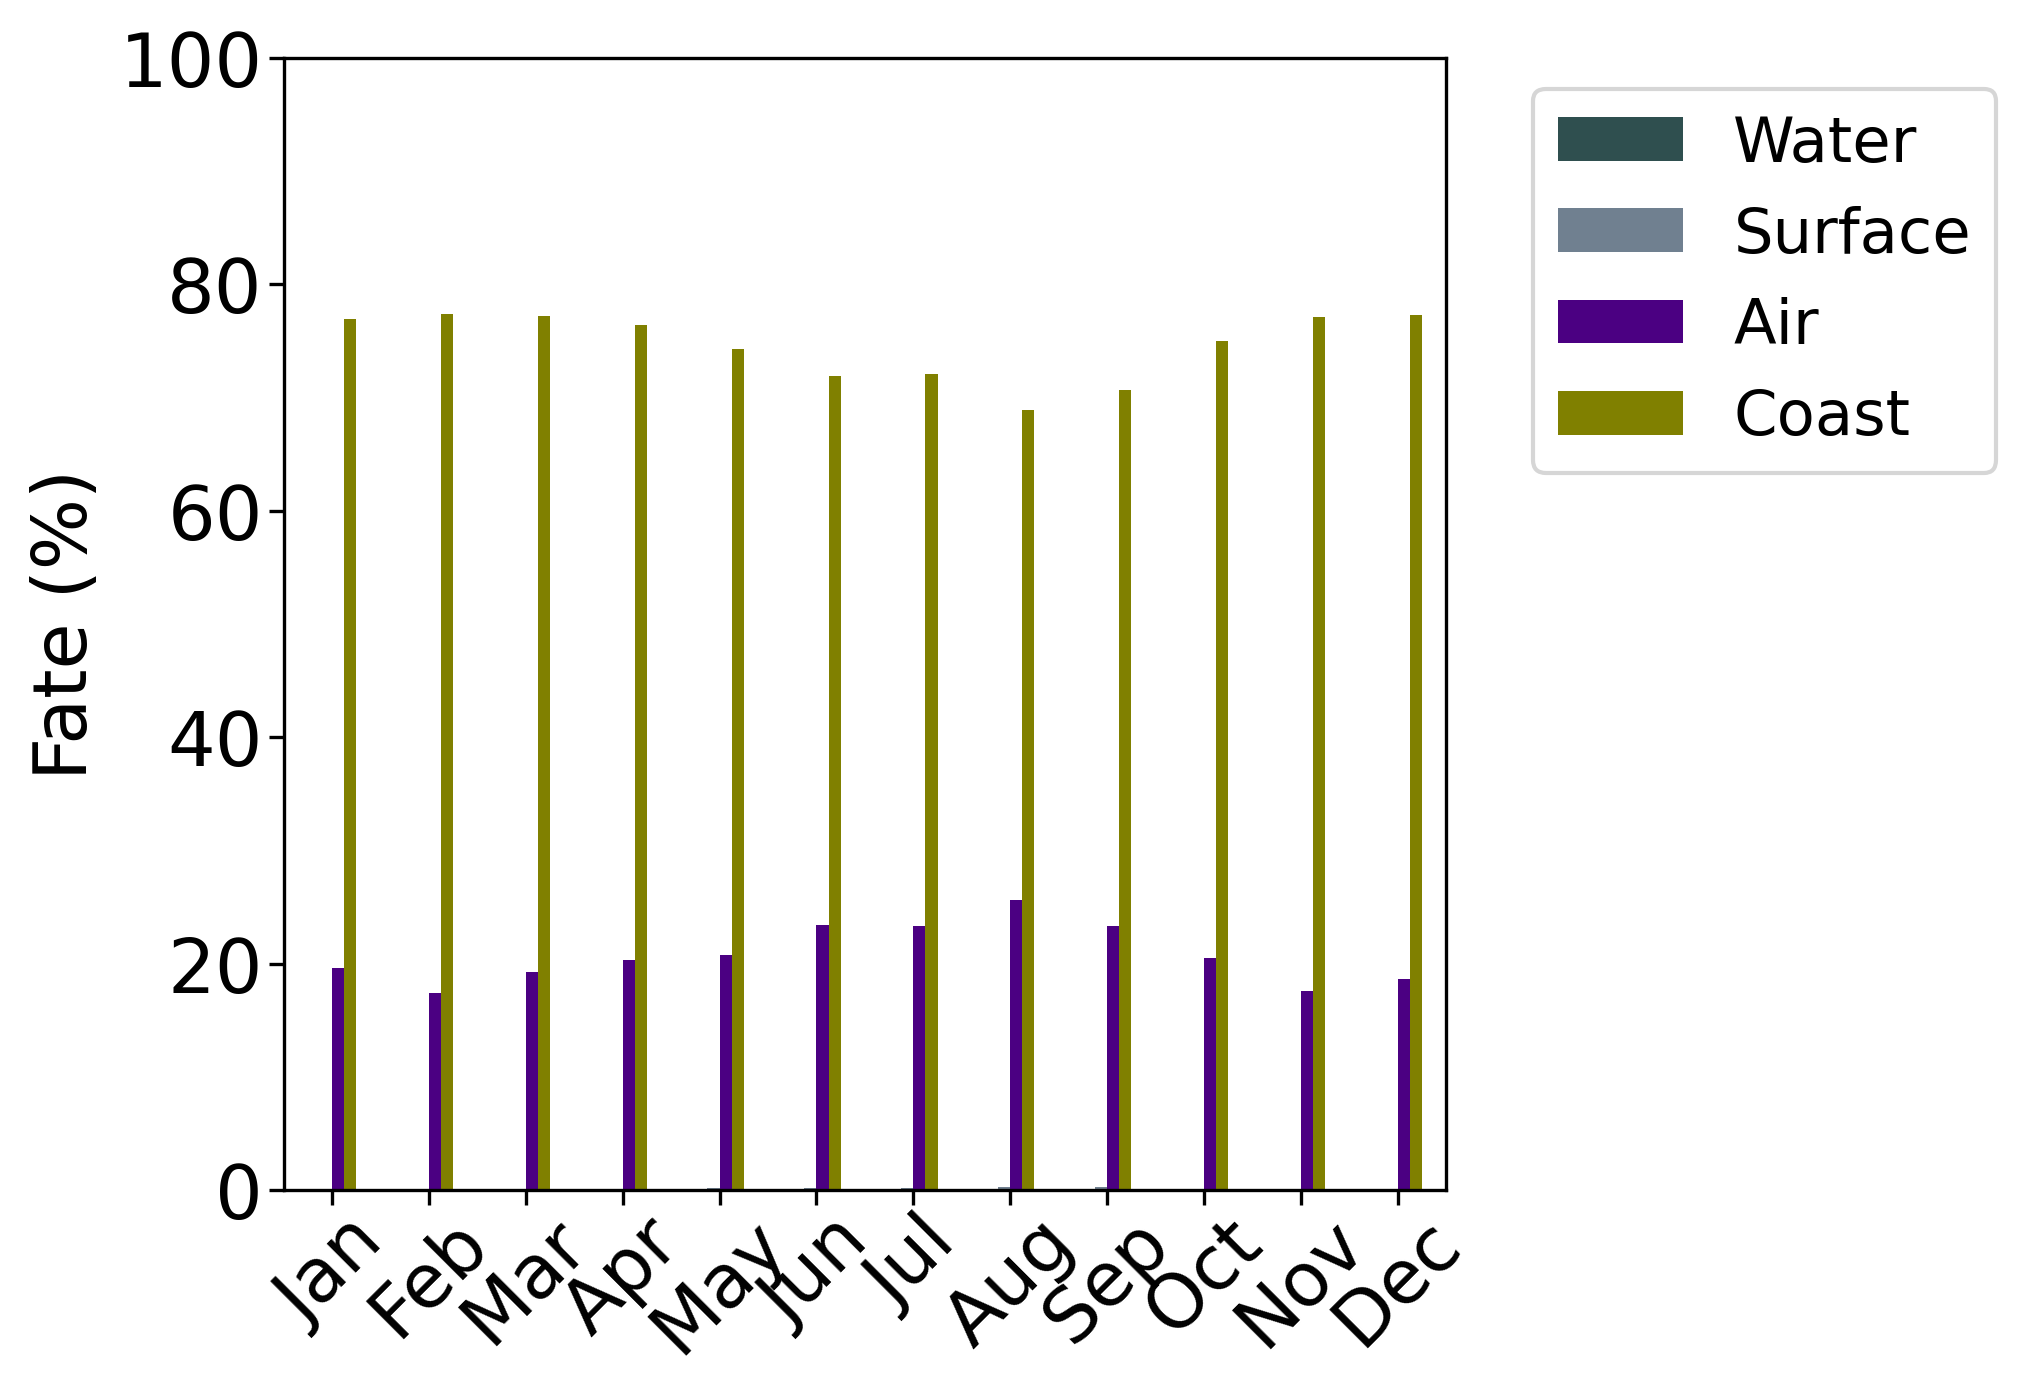

In [11]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5, 5),
                       gridspec_kw={
                           'width_ratios': [1],
                           'height_ratios': [1],
                       'wspace': 0.4,
                       'hspace': 0.2})
persist_df['median'].plot(ax=ax,
    kind="bar",
    color=['darkslategrey','slategrey','indigo','olive'],
    legend=False,          
    #yerr=yerr_reorg, #np.append(error_max, error_min, axis=0), 
    error_kw=dict(lw=3, capsize=4, capthick=3),
    ecolor='lightsteelblue'
)
ax.set_ylabel("Fate (%)")
ax.legend(bbox_to_anchor=(1.5, 1), loc='upper right')
ax.set_ylim(0,100)
ax.set_yticks([0, 20, 40, 60, 80, 100])
ax.set_xticklabels(
   months,rotation=45
)

plt.savefig(graphics_dir/'Fate_ByMonth_xmonth_1panel_MedianErr.png')

### Plot by location

In [12]:
# Add Quantiles to opperations
opperations = ['median','mean','std','min','max','Q1','Q2','Q3']
location = ["water","sfc","air","beach"]
persist_df_loc={}
print('-------------------')
print('BUILDING DATAFRAMES')
print('-------------------')
for opp in opperations:
    print('\n\n \_ ', opp)
    persist_df_loc[opp] = pd.DataFrame({
        "Jan":[persist[opp]["Jan"][loc] for loc in location],
        "Feb":[persist[opp]["Feb"][loc] for loc in location],
        "Mar":[persist[opp]["Mar"][loc] for loc in location],
        "Apr":[persist[opp]["Apr"][loc] for loc in location],
        "May":[persist[opp]["May"][loc] for loc in location],
        "Jun":[persist[opp]["Jun"][loc] for loc in location],
        "Jul":[persist[opp]["Jul"][loc] for loc in location],
        "Aug":[persist[opp]["Aug"][loc] for loc in location],
        "Sep":[persist[opp]["Sep"][loc] for loc in location],
        "Oct":[persist[opp]["Oct"][loc] for loc in location],
        "Nov":[persist[opp]["Nov"][loc] for loc in location],
        "Dec":[persist[opp]["Dec"][loc] for loc in location],
        }, 
        index=location
    )
    persist_df_loc[opp] = persist_df_loc[opp].rename_axis(opp, axis=1)
    print(persist_df_loc[opp]) 

-------------------
BUILDING DATAFRAMES
-------------------


 \_  median
median        Jan        Feb        Mar        Apr        May        Jun  \
water    0.063286   0.057967   0.056027   0.050425   0.047886   0.048949   
sfc      0.068682   0.096455   0.113725   0.073617   0.162744   0.154321   
air     19.632258  17.433799  19.228662  20.302542  20.742258  23.411081   
beach   76.962088  77.366648  77.174818  76.353456  74.289779  71.883969   

median        Jul        Aug        Sep        Oct        Nov        Dec  
water    0.044325   0.051929   0.048791   0.047692   0.051903   0.066564  
sfc      0.205800   0.242292   0.259657   0.103639   0.047991   0.039569  
air     23.300721  25.626113  23.291487  20.465185  17.583779  18.624889  
beach   72.056913  68.862403  70.669730  75.003900  77.076892  77.260684  


 \_  mean
mean         Jan        Feb        Mar        Apr        May        Jun  \
water   4.226289   3.894716   3.381294   2.607543   1.576670   1.820309   
sfc     

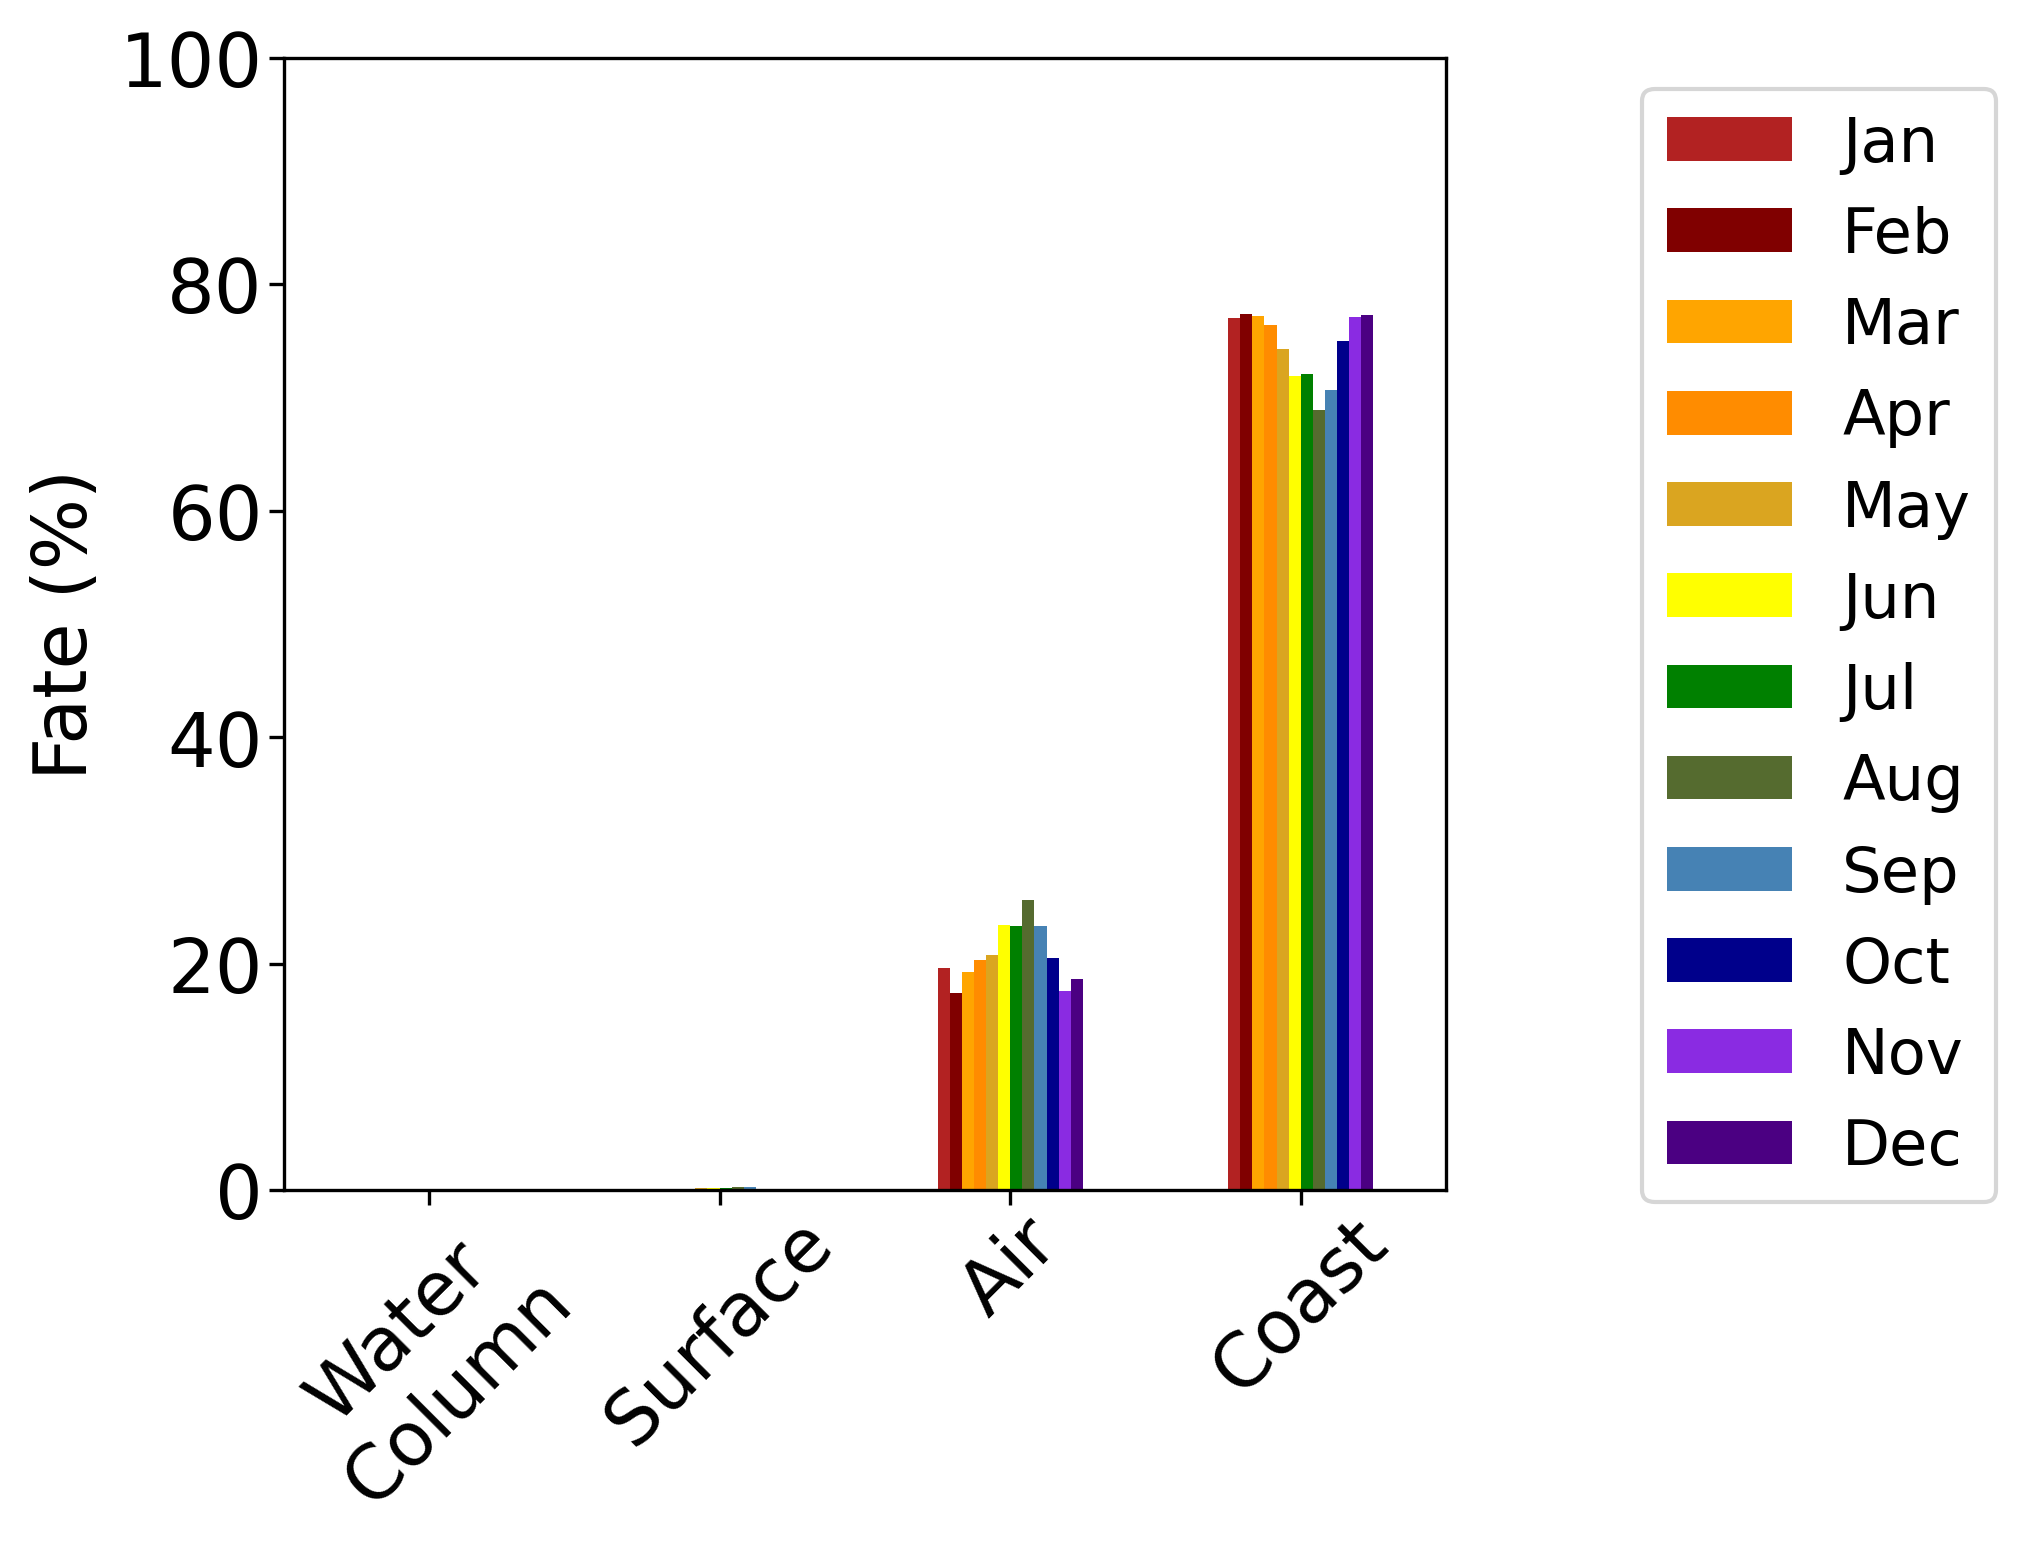

In [13]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5, 5),
                       gridspec_kw={
                           'width_ratios': [1],
                           'height_ratios': [1],
                       'wspace': 0.4,
                       'hspace': 0.2})
persist_df_loc['median'].plot(ax=ax,
    kind="bar",
    color=['firebrick','maroon','orange','darkorange','goldenrod','yellow',
           'green', 'darkolivegreen','steelblue','darkblue',
          'blueviolet','indigo'],
    legend=False,          
    #yerr=yerr_reorg, #np.append(error_max, error_min, axis=0), 
    error_kw=dict(lw=3, capsize=4, capthick=3),
    ecolor='lightsteelblue'
)
ax.set_ylabel("Fate (%)")
ax.legend(bbox_to_anchor=(1.5, 1), loc='upper right')
ax.set_ylim(0,100)
ax.set_yticks([0, 20, 40, 60, 80, 100])
ax.set_xticklabels(
   ["Water\nColumn","Surface","Air","Coast"],rotation=45
)

plt.savefig(graphics_dir/'Fate_ByMonth_xLoc_1panel_MedianErr.png')